In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths


In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.metrics import mean_squared_error,mean_absolute_error


from tqdm import trange
import copy
from pathlib import Path
import matplotlib.pyplot as plt


data = pd.read_csv('continuous_flights_data.csv',parse_dates=['SD','DT','SA','AT'])

In [3]:
year_begin = pd.to_datetime('2015-1-1')
data['time_idx'] = ((pd.to_datetime(data['Date']) - year_begin).dt.total_seconds() / (24 * 60 * 60)).astype(int)

In [4]:
data = data[data['CANCELLED'] == 0]
data = data[data['DIVERTED'] == 0]
data = data.drop(['AIRLINE' ,'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WF', 'WN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ELAPSED_TIME', 
                  'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'Date','WHEELS_OFF', 'WHEELS_ON', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON'] ,axis = 1)

In [5]:
counts = data['FLIGHT_ID'].value_counts()
unique_flight_ids = counts[counts <= 180].index

data = data[~data['FLIGHT_ID'].isin(unique_flight_ids)]

In [6]:
max_prediction_length = 14
max_encoder_length = 90
training_cutoff = 300

In [7]:
valid_flight_ids = data[data['time_idx'] <= training_cutoff]['FLIGHT_ID'].unique()
valid_origin = data[data['time_idx'] <= training_cutoff]['ORIGIN_AIRPORT_IATA'].unique()
valid_des = data[data['time_idx'] <= training_cutoff]['DESTINATION_AIRPORT_IATA'].unique()
valid_tail_numbers = data[data['time_idx'] <= training_cutoff]['TAIL_NUMBER'].unique()
data = data[(data['FLIGHT_ID'].isin(valid_flight_ids)) & (data['ORIGIN_AIRPORT_IATA'].isin(valid_origin)) & (data['DESTINATION_AIRPORT_IATA'].isin(valid_des)) & (data['TAIL_NUMBER'].isin(valid_tail_numbers))]

In [8]:
for col in ['SD','DT','SA','AT']:
    data[f'{col}_YEAR'] = data[col].dt.year
    data[f'{col}_MONTH'] = data[col].dt.month
    data[f'{col}_DAY'] = data[col].dt.day
    data[f'{col}_H'] = data[col].dt.hour
    data[f'{col}_M'] = data[col].dt.minute
    data[f'{col}_S'] = data[col].dt.second
    data.drop(col, axis=1, inplace=True)

In [9]:
data.drop(['YEAR','MONTH','DAY'],axis=1 ,inplace=True)

In [10]:
data["FLIGHT_ID"] = data["FLIGHT_ID"].astype(str).astype("category")
data["TAIL_NUMBER"] = data["TAIL_NUMBER"].astype(str).astype("category")
data["ORIGIN_AIRPORT_IATA"] = data["ORIGIN_AIRPORT_IATA"].astype(str).astype("category")
data["DESTINATION_AIRPORT_IATA"] = data["DESTINATION_AIRPORT_IATA"].astype(str).astype("category")

#data.iloc[:,-6*4:] = data.iloc[:,-6*4:].astype(str).astype("category")

In [11]:
data = data.reset_index(drop=True)

In [12]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="ARRIVAL_DELAY",
    group_ids=["FLIGHT_ID"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["FLIGHT_ID", 'ORIGIN_AIRPORT_IATA', 'DESTINATION_AIRPORT_IATA'],
    static_reals=["DISTANCE"],
    time_varying_known_categoricals=['TAIL_NUMBER'],
    time_varying_known_reals=["time_idx", "SCHEDULED_TIME", 'DAY_OF_WEEK', 'SD_YEAR', 'SD_MONTH', 'SD_DAY', 'SD_H', 'SD_M', 'SD_S', 'SA_YEAR', 'SA_MONTH',
       'SA_DAY', 'SA_H', 'SA_M', 'SA_S'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'DEPARTURE_DELAY', 'TAXI_OUT', 'AIR_TIME',
       'TAXI_IN', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
       'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'
    ],
    target_normalizer=GroupNormalizer(
        groups=["FLIGHT_ID"] , transformation="count"
    ), 
    allow_missing_timesteps = True,
    add_relative_time_idx=True,
    add_target_scales=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx > training_cutoff-max_encoder_length], predict=False, stop_randomization=True)

batch_size = 128 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=1)

In [13]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs = 50,
    gradient_clip_val=1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=32,
    attention_head_size=6,
    dropout=0.2,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
    # loss = RMSE(),
    optimizer="Ranger",
    reduce_on_plateau_patience=2,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 397.6k


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0097723722095581
Restoring states from the checkpoint path at c:\Users\Lenovo\Desktop\.lr_find_6602c22f-0590-4a8c-95f3-4d6397118e50.ckpt
Restored all states from the checkpoint at c:\Users\Lenovo\Desktop\.lr_find_6602c22f-0590-4a8c-95f3-4d6397118e50.ckpt


suggested learning rate: 0.0097723722095581


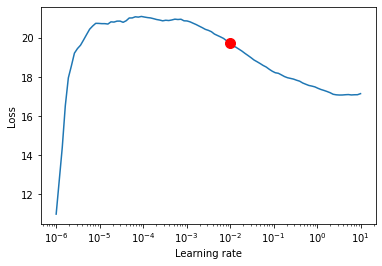

In [14]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [15]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor() 
logger = TensorBoardLogger("lightning_logs") 

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=1e-2,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=32,
    attention_head_size=6,
    dropout=0.2,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
    # loss = RMSE(),
    log_interval=10,
    optimizer="Ranger",
    reduce_on_plateau_patience=2,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 397.6k


In [16]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 110 K 
3  | prescalers                         | ModuleDict                      | 1.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 14.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 139 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 80.5 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [17]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [18]:
raw_prediction = best_tft.predict(
    validation.filter(lambda x: (x.FLIGHT_ID == 'AA1042')),
    mode = 'raw',
    return_x = True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 13.352982
MAE: 12.518571


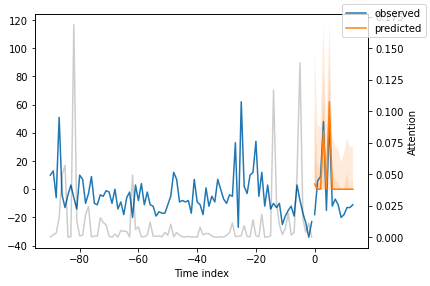

In [19]:
idx = 0
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx = idx)
print('RMSE:',np.sqrt(mean_squared_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy())))
print('MAE:',mean_absolute_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy()))

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x450 with 1 Axes>}

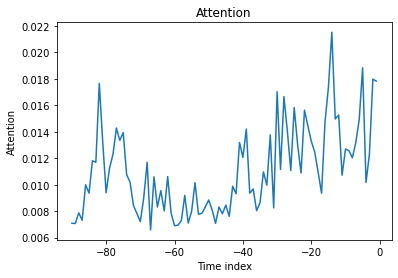

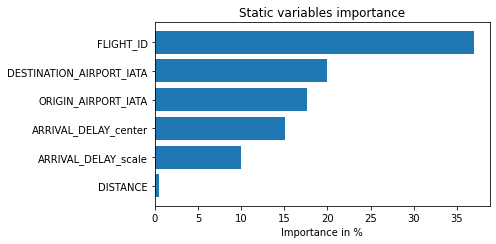

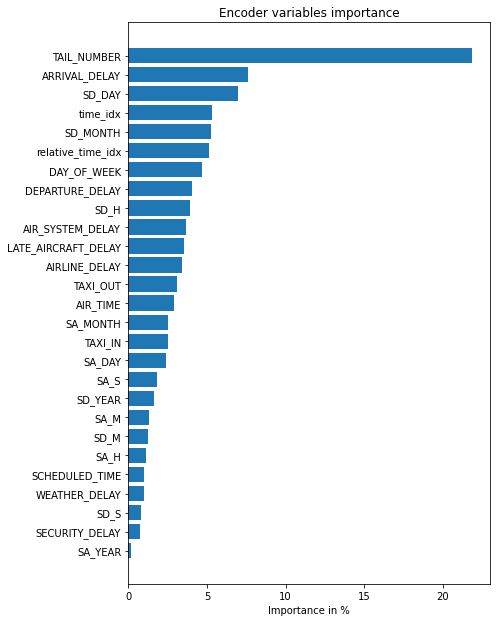

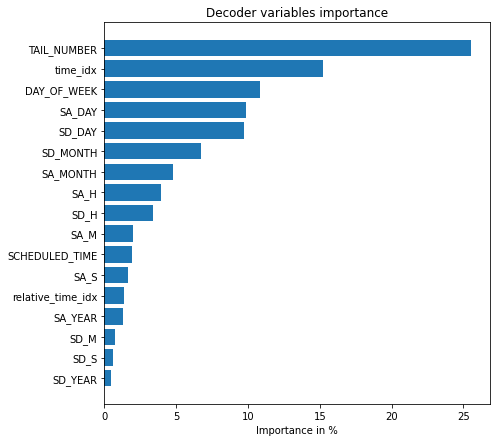

In [20]:
interpretation = best_tft.interpret_output(raw_prediction.output, reduction='sum')
best_tft.plot_interpretation(interpretation)

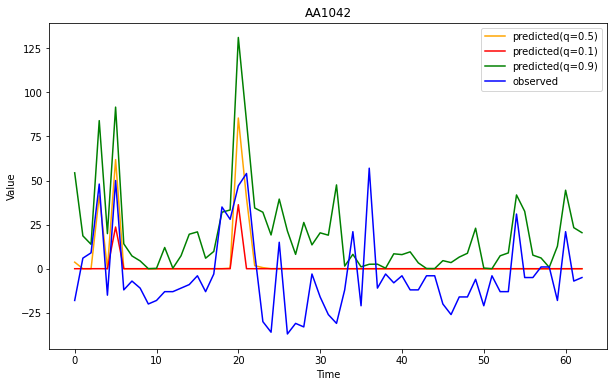

RMSE: 19.250401774062986
MAE: 15.607518058244336


In [21]:
pred_AA1042 = []
target_AA1042 = []
pred_AA1042_1 = []
pred_AA1042_9 = []

pred_AA1042.extend(raw_prediction.output[0][0].T[3].detach().cpu().tolist())
target_AA1042.extend(raw_prediction.x['decoder_target'][0].detach().cpu().tolist())
pred_AA1042.extend(raw_prediction.output[0][14].T[3].detach().cpu().tolist())
target_AA1042.extend(raw_prediction.x['decoder_target'][14].detach().cpu().tolist())
pred_AA1042.extend(raw_prediction.output[0][28].T[3].detach().cpu().tolist())
target_AA1042.extend(raw_prediction.x['decoder_target'][28].detach().cpu().tolist())
pred_AA1042.extend(raw_prediction.output[0][40].T[3].detach().cpu().tolist())
target_AA1042.extend(raw_prediction.x['decoder_target'][40].detach().cpu().tolist())
pred_AA1042.extend(raw_prediction.output[0][45].T[3][7:].detach().cpu().tolist())
target_AA1042.extend(raw_prediction.x['decoder_target'][45][7:].detach().cpu().tolist())

pred_AA1042_1.extend(raw_prediction.output[0][0].T[1].detach().cpu().tolist())
pred_AA1042_9.extend(raw_prediction.output[0][0].T[5].detach().cpu().tolist())
pred_AA1042_1.extend(raw_prediction.output[0][14].T[1].detach().cpu().tolist())
pred_AA1042_9.extend(raw_prediction.output[0][14].T[5].detach().cpu().tolist())
pred_AA1042_1.extend(raw_prediction.output[0][28].T[1].detach().cpu().tolist())
pred_AA1042_9.extend(raw_prediction.output[0][28].T[5].detach().cpu().tolist())
pred_AA1042_1.extend(raw_prediction.output[0][40].T[1].detach().cpu().tolist())
pred_AA1042_9.extend(raw_prediction.output[0][40].T[5].detach().cpu().tolist())
pred_AA1042_1.extend(raw_prediction.output[0][45].T[1][7:].detach().cpu().tolist())
pred_AA1042_9.extend(raw_prediction.output[0][45].T[5][7:].detach().cpu().tolist())

plt.figure(figsize=(10,6))
plt.plot(pred_AA1042, label = 'predicted(q=0.5)',color = 'orange')
plt.plot(pred_AA1042_1, label = 'predicted(q=0.1)',color = 'red')
plt.plot(pred_AA1042_9, label = 'predicted(q=0.9)',color = 'green')
plt.plot(target_AA1042, label = 'observed', color = 'blue')
plt.title('AA1042')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print('RMSE:',np.sqrt(mean_squared_error(y_true=target_AA1042, y_pred=pred_AA1042)))
print('MAE:',mean_absolute_error(y_true=target_AA1042, y_pred=pred_AA1042))

In [22]:
raw_prediction = best_tft.predict(
    validation.filter(lambda x: (x.FLIGHT_ID == 'AA1406')),
    mode = 'raw',
    return_x = True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 14.211681
MAE: 10.898215


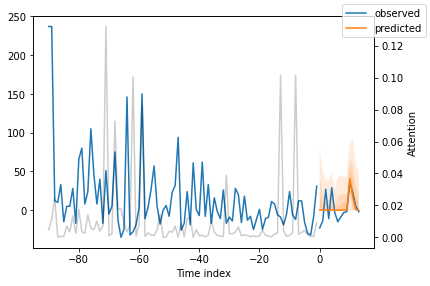

In [23]:
idx = 0
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx = idx)
print('RMSE:',np.sqrt(mean_squared_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy())))
print('MAE:',mean_absolute_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy()))

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x450 with 1 Axes>}

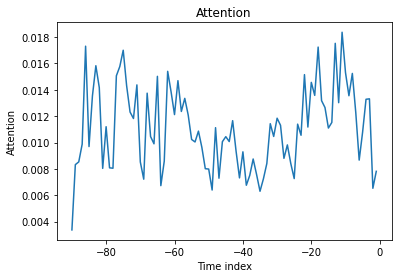

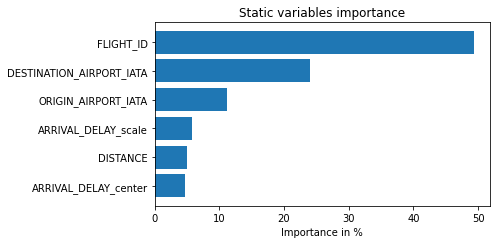

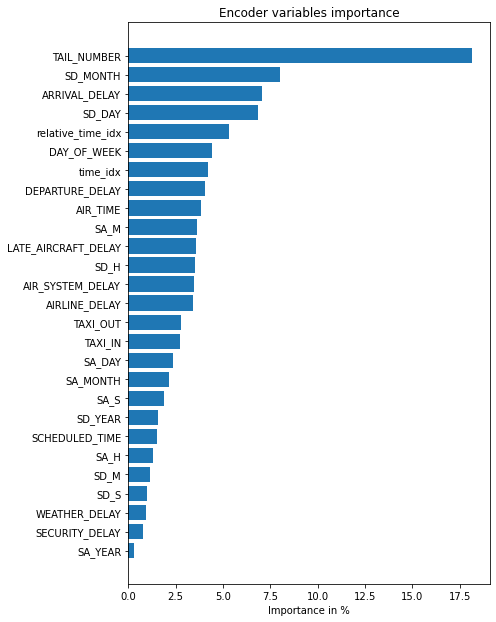

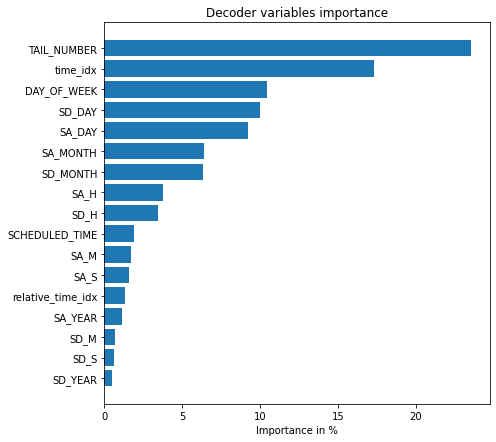

In [24]:
interpretation = best_tft.interpret_output(raw_prediction.output, reduction='sum')
best_tft.plot_interpretation(interpretation)

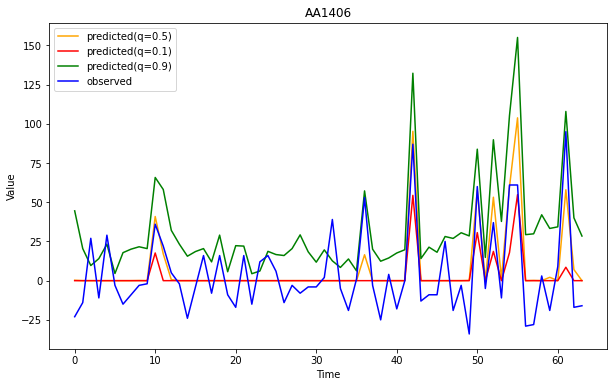

RMSE: 17.24126767108537
MAE: 13.514985451240001


In [25]:
pred_AA1406 = []
target_AA1406 = []
pred_AA1406_1 = []
pred_AA1406_9 = []

pred_AA1406.extend(raw_prediction.output[0][0].T[3].detach().cpu().tolist())
target_AA1406.extend(raw_prediction.x['decoder_target'][0].detach().cpu().tolist())
pred_AA1406.extend(raw_prediction.output[0][12].T[3].detach().cpu().tolist())
target_AA1406.extend(raw_prediction.x['decoder_target'][12].detach().cpu().tolist())
pred_AA1406.extend(raw_prediction.output[0][26].T[3].detach().cpu().tolist())
target_AA1406.extend(raw_prediction.x['decoder_target'][26].detach().cpu().tolist())
pred_AA1406.extend(raw_prediction.output[0][40].T[3].detach().cpu().tolist())
target_AA1406.extend(raw_prediction.x['decoder_target'][40].detach().cpu().tolist())
pred_AA1406.extend(raw_prediction.output[0][48].T[3][6:].detach().cpu().tolist())
target_AA1406.extend(raw_prediction.x['decoder_target'][48][6:].detach().cpu().tolist())

pred_AA1406_1.extend(raw_prediction.output[0][0].T[1].detach().cpu().tolist())
pred_AA1406_9.extend(raw_prediction.output[0][0].T[5].detach().cpu().tolist())
pred_AA1406_1.extend(raw_prediction.output[0][12].T[1].detach().cpu().tolist())
pred_AA1406_9.extend(raw_prediction.output[0][12].T[5].detach().cpu().tolist())
pred_AA1406_1.extend(raw_prediction.output[0][26].T[1].detach().cpu().tolist())
pred_AA1406_9.extend(raw_prediction.output[0][26].T[5].detach().cpu().tolist())
pred_AA1406_1.extend(raw_prediction.output[0][40].T[1].detach().cpu().tolist())
pred_AA1406_9.extend(raw_prediction.output[0][40].T[5].detach().cpu().tolist())
pred_AA1406_1.extend(raw_prediction.output[0][48].T[1][6:].detach().cpu().tolist())
pred_AA1406_9.extend(raw_prediction.output[0][48].T[5][6:].detach().cpu().tolist())

plt.figure(figsize=(10,6))
plt.plot(pred_AA1406, label = 'predicted(q=0.5)',color = 'orange')
plt.plot(pred_AA1406_1, label = 'predicted(q=0.1)',color = 'red')
plt.plot(pred_AA1406_9, label = 'predicted(q=0.9)',color = 'green')
plt.plot(target_AA1406, label = 'observed', color = 'blue')
plt.title('AA1406')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print('RMSE:',np.sqrt(mean_squared_error(y_true=target_AA1406, y_pred=pred_AA1406)))
print('MAE:',mean_absolute_error(y_true=target_AA1406, y_pred=pred_AA1406))

In [26]:
raw_prediction = best_tft.predict(
    validation.filter(lambda x: (x.FLIGHT_ID == 'AA1486')),
    mode = 'raw',
    return_x = True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 12.392876
MAE: 9.771945


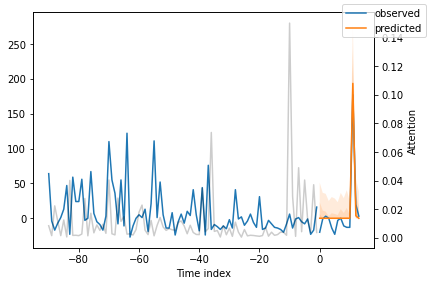

In [27]:
idx = 0
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx = idx)
print('RMSE:',np.sqrt(mean_squared_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy())))
print('MAE:',mean_absolute_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy()))

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x450 with 1 Axes>}

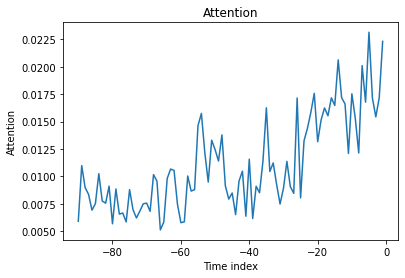

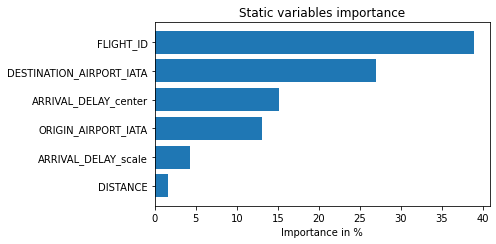

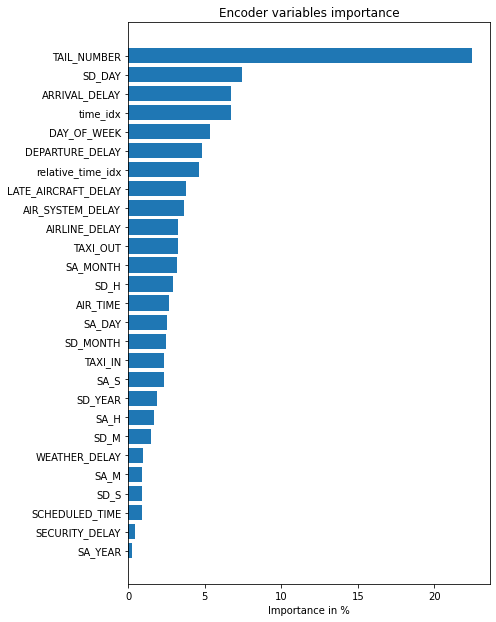

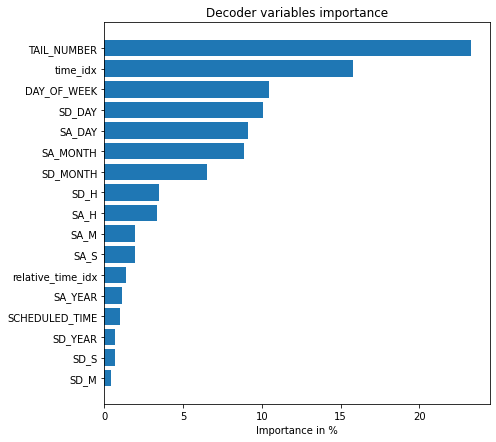

In [28]:
interpretation = best_tft.interpret_output(raw_prediction.output, reduction='sum')
best_tft.plot_interpretation(interpretation)

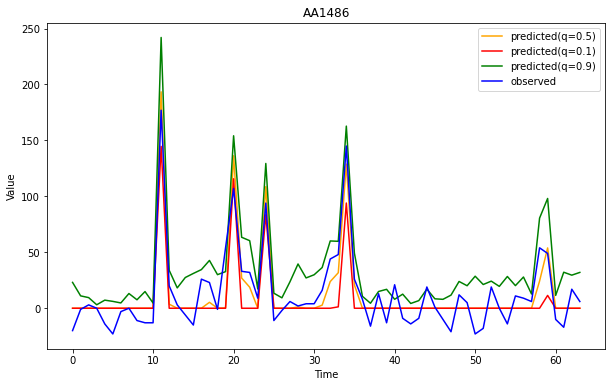

RMSE: 15.198384852574138
MAE: 12.2342541745587


In [29]:
pred_AA1486 = []
target_AA1486 = []
pred_AA1486_1 = []
pred_AA1486_9 = []

pred_AA1486.extend(raw_prediction.output[0][0].T[3].detach().cpu().tolist())
target_AA1486.extend(raw_prediction.x['decoder_target'][0].detach().cpu().tolist())
pred_AA1486.extend(raw_prediction.output[0][13].T[3].detach().cpu().tolist())
target_AA1486.extend(raw_prediction.x['decoder_target'][13].detach().cpu().tolist())
pred_AA1486.extend(raw_prediction.output[0][27].T[3].detach().cpu().tolist())
target_AA1486.extend(raw_prediction.x['decoder_target'][27].detach().cpu().tolist())
pred_AA1486.extend(raw_prediction.output[0][41].T[3].detach().cpu().tolist())
target_AA1486.extend(raw_prediction.x['decoder_target'][41].detach().cpu().tolist())
pred_AA1486.extend(raw_prediction.output[0][49].T[3][6:].detach().cpu().tolist())
target_AA1486.extend(raw_prediction.x['decoder_target'][49][6:].detach().cpu().tolist())

pred_AA1486_1.extend(raw_prediction.output[0][0].T[1].detach().cpu().tolist())
pred_AA1486_9.extend(raw_prediction.output[0][0].T[5].detach().cpu().tolist())
pred_AA1486_1.extend(raw_prediction.output[0][13].T[1].detach().cpu().tolist())
pred_AA1486_9.extend(raw_prediction.output[0][13].T[5].detach().cpu().tolist())
pred_AA1486_1.extend(raw_prediction.output[0][27].T[1].detach().cpu().tolist())
pred_AA1486_9.extend(raw_prediction.output[0][27].T[5].detach().cpu().tolist())
pred_AA1486_1.extend(raw_prediction.output[0][41].T[1].detach().cpu().tolist())
pred_AA1486_9.extend(raw_prediction.output[0][41].T[5].detach().cpu().tolist())
pred_AA1486_1.extend(raw_prediction.output[0][49].T[1][6:].detach().cpu().tolist())
pred_AA1486_9.extend(raw_prediction.output[0][49].T[5][6:].detach().cpu().tolist())

plt.figure(figsize=(10,6))
plt.plot(pred_AA1486, label = 'predicted(q=0.5)',color = 'orange')
plt.plot(pred_AA1486_1, label = 'predicted(q=0.1)',color = 'red')
plt.plot(pred_AA1486_9, label = 'predicted(q=0.9)',color = 'green')
plt.plot(target_AA1486, label = 'observed', color = 'blue')
plt.title('AA1486')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print('RMSE:',np.sqrt(mean_squared_error(y_true=target_AA1486, y_pred=pred_AA1486)))
print('MAE:',mean_absolute_error(y_true=target_AA1486, y_pred=pred_AA1486))

In [30]:
raw_prediction = best_tft.predict(
    validation.filter(lambda x: (x.FLIGHT_ID == 'AA1567')),
    mode = 'raw',
    return_x = True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 21.982513
MAE: 19.326244


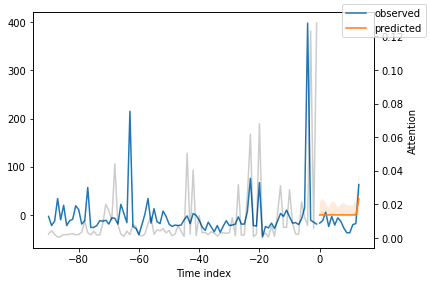

In [31]:
idx = 0
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx = idx)
print('RMSE:',np.sqrt(mean_squared_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy())))
print('MAE:',mean_absolute_error(y_true=raw_prediction.x['decoder_target'][idx].detach().cpu().numpy(), y_pred=raw_prediction.output[0][idx].T[3].detach().cpu().numpy()))

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x630 with 1 Axes>,
 'decoder_variables': <Figure size 504x450 with 1 Axes>}

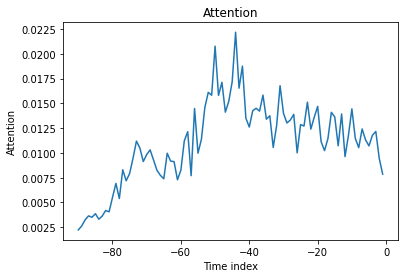

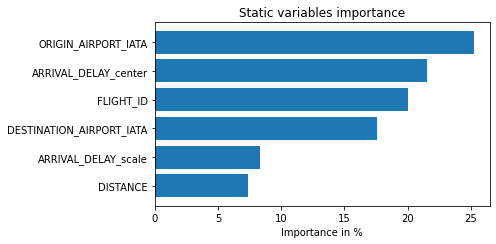

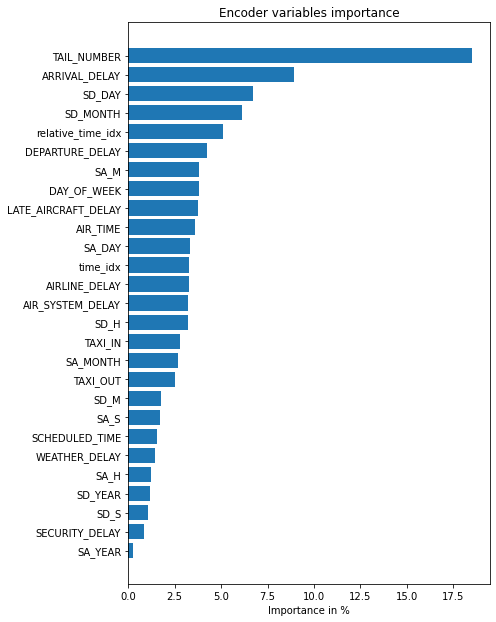

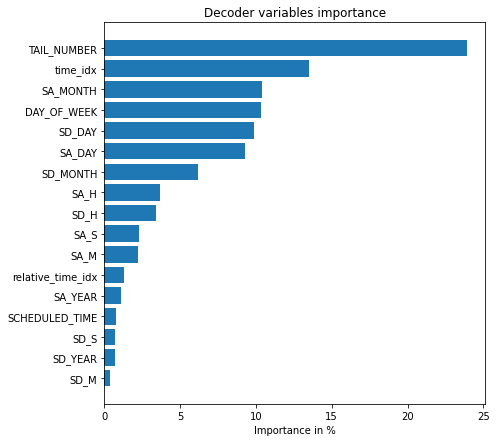

In [32]:
interpretation = best_tft.interpret_output(raw_prediction.output, reduction='sum')
best_tft.plot_interpretation(interpretation)

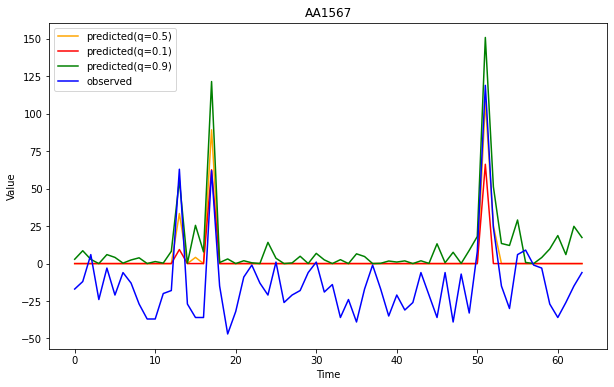

RMSE: 22.8690550112184
MAE: 19.280141634920632


In [33]:
pred_AA1567 = []
target_AA1567 = []
pred_AA1567_1 = []
pred_AA1567_9 = []
pred_AA1567.extend(raw_prediction.output[0][0].T[3].detach().cpu().tolist())
target_AA1567.extend(raw_prediction.x['decoder_target'][0].detach().cpu().tolist())
pred_AA1567.extend(raw_prediction.output[0][14].T[3].detach().cpu().tolist())
target_AA1567.extend(raw_prediction.x['decoder_target'][14].detach().cpu().tolist())
pred_AA1567.extend(raw_prediction.output[0][28].T[3].detach().cpu().tolist())
target_AA1567.extend(raw_prediction.x['decoder_target'][28].detach().cpu().tolist())
pred_AA1567.extend(raw_prediction.output[0][42].T[3].detach().cpu().tolist())
target_AA1567.extend(raw_prediction.x['decoder_target'][42].detach().cpu().tolist())
pred_AA1567.extend(raw_prediction.output[0][50].T[3][6:].detach().cpu().tolist())
target_AA1567.extend(raw_prediction.x['decoder_target'][50][6:].detach().cpu().tolist())

pred_AA1567_1.extend(raw_prediction.output[0][0].T[1].detach().cpu().tolist())
pred_AA1567_9.extend(raw_prediction.output[0][0].T[5].detach().cpu().tolist())
pred_AA1567_1.extend(raw_prediction.output[0][14].T[1].detach().cpu().tolist())
pred_AA1567_9.extend(raw_prediction.output[0][14].T[5].detach().cpu().tolist())
pred_AA1567_1.extend(raw_prediction.output[0][28].T[1].detach().cpu().tolist())
pred_AA1567_9.extend(raw_prediction.output[0][28].T[5].detach().cpu().tolist())
pred_AA1567_1.extend(raw_prediction.output[0][42].T[1].detach().cpu().tolist())
pred_AA1567_9.extend(raw_prediction.output[0][42].T[5].detach().cpu().tolist())
pred_AA1567_1.extend(raw_prediction.output[0][50].T[1][6:].detach().cpu().tolist())
pred_AA1567_9.extend(raw_prediction.output[0][50].T[5][6:].detach().cpu().tolist())

plt.figure(figsize=(10,6))
plt.plot(pred_AA1567, label = 'predicted(q=0.5)',color = 'orange')
plt.plot(pred_AA1567_1, label = 'predicted(q=0.1)',color = 'red')
plt.plot(pred_AA1567_9, label = 'predicted(q=0.9)',color = 'green')
plt.plot(target_AA1567, label = 'observed', color = 'blue')
plt.title('AA1567')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print('RMSE:',np.sqrt(mean_squared_error(y_true=target_AA1567, y_pred=pred_AA1567)))
print('MAE:',mean_absolute_error(y_true=target_AA1567, y_pred=pred_AA1567))